In [1]:
from desc import set_device
set_device("gpu")

import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put
from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison
from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile
from desc.magnetic_fields import SplineMagneticField
import desc.examples

#from desc.geometry.utils import rpz2xyz, rpz2xyz_vec
from desc.compute import rpz2xyz, rpz2xyz_vec
from desc.coils import *

from desc.utils import flatten_list
from desc.compute.utils import cross
from desc.compute.utils import dot

from desc.regcoil import run_regcoil

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
#eqname = "/home/dpanici/DESC/work/opt_nt_tao/LM_9__N_9__WQS_2__alpha_0__QSCIND_10/LM_9__N_9__WQS_2__alpha_0__QSCIND_10_qsc_10_opt9.h5"

#eq = "/home/fcastro/LMStell/regcoil/ellNFP4_init_smallish.h5" # Simple result with a poloidal current, vacuum equilibrium
eqname =  "/home/fcastro/LMStell/regcoil/precise_QA_output.h5" #vacuum equilibrium
#eq =  "/home/fcastro/LMStell/regcoil/precise_QA_offset_0.1m.h5" #vacuum equilibrium

eq = load(eqname)

In [3]:
Rmax = 1.4
Rmin = 0.6
Zmax = 1
Zmin = -1
a = 0.5
R0 = (Rmax+Rmin)/2

surf_winding = FourierRZToroidalSurface(R_lmn=[R0, a],Z_lmn=[0.0,-a],
                                        modes_R=np.array([[0,0],[1,0]]),
                                        modes_Z=np.array([[0,0],[-1,0]]),
                                        sym=True,
                                        NFP=eq.NFP
                                       )

(<Figure size 864x720 with 6 Axes>,
 array([<AxesSubplot: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

/home/fcastro/.conda/envs/desc-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


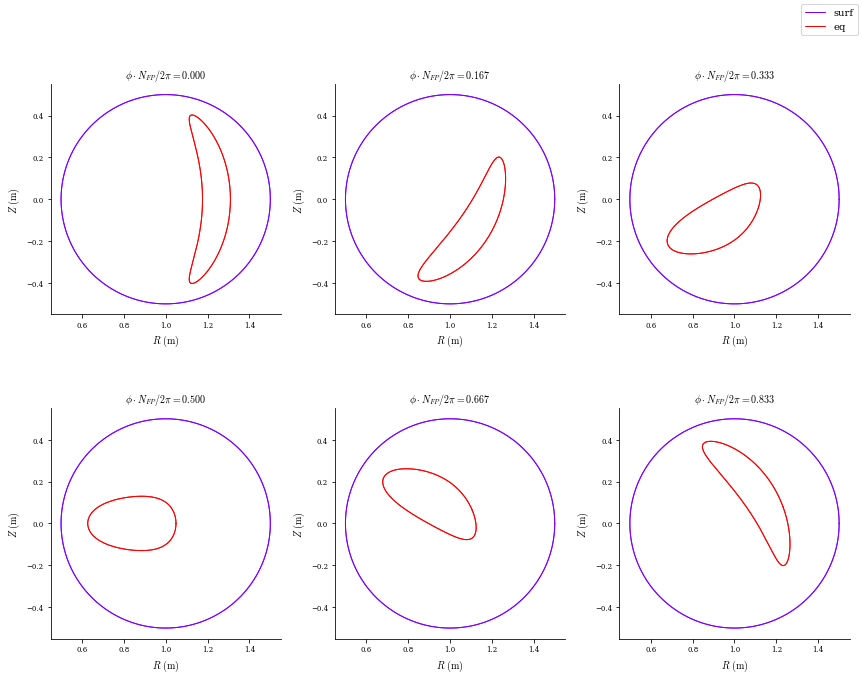

In [4]:
eq_surf = Equilibrium(surface = surf_winding)
plot_comparison([eq_surf,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

Starting Jacobian Calculation 0/1
Jacobian Calculation finished, took 2294.0661668777466 s
##########################################
Calculating Phi_SV for alpha = 1.00000e-19
##########################################


<Figure size 720x720 with 0 Axes>

/home/fcastro/.conda/envs/desc-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


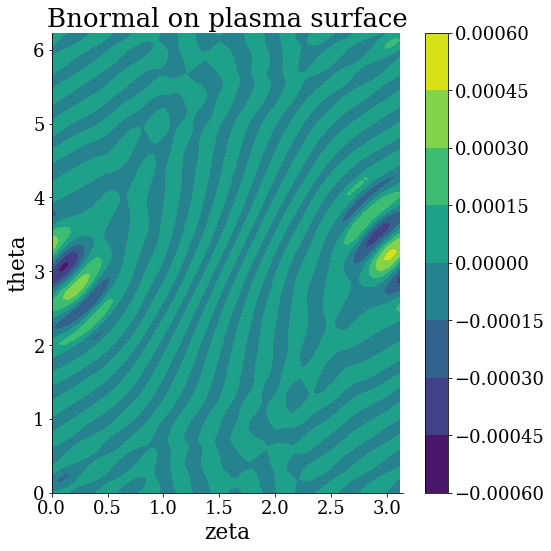

<Figure size 720x720 with 0 Axes>

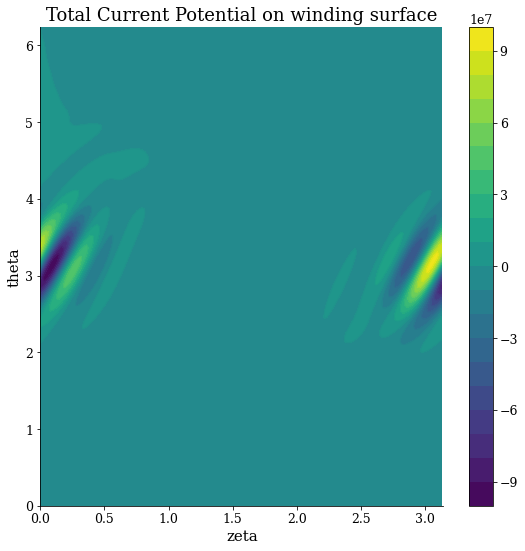

In [5]:
#surf_winding = FourierRZToroidalSurface(
#        R_lmn=np.array([10, 2]),
#        Z_lmn=np.array([-2]),
#        modes_R=np.array([[0, 0], [1, 0]]),
#        modes_Z=np.array([[-1, 0]]),
#        sym=True,
#        NFP=4,
#    )

surface_current_field, _, _, chi_B, _ = run_regcoil(
        basis_M=12,
        basis_N=12,
        eqname=eq,
        eval_grid_M=60,
        eval_grid_N=60,
        source_grid_M=80,
        source_grid_N=100,
        alpha=1e-19,
        winding_surf = surf_winding,
        show_plots=True,
    )

In [6]:
egrid = LinearGrid(M=200, N=200)

#coords = eq.compute(["R", "phi", "Z", "B"])
coords = eq.compute(["R", "phi", "Z"], grid = egrid)
#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
B_from_surf = surface_current_field.compute_magnetic_field(
    coords, grid=egrid
)

/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(
/home/fcastro/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(


In [7]:
max(jnp.sqrt(dot(B_from_surf,B_from_surf)))

Array(1.13937666, dtype=float64)

(0.0, 3.141592653589793)

/home/fcastro/.conda/envs/desc-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


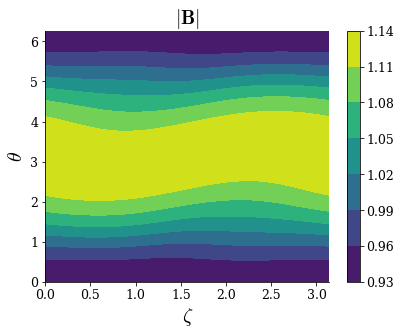

In [8]:
# B on the surface
mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

#for i in range(8,11):
#    phi_test = residual[r*i:r*(i+1)]

plt.figure(figsize=(6,5)).set_tight_layout(False)
plt.contourf(egrid.nodes[egrid.unique_zeta_idx,2],egrid.nodes[egrid.unique_theta_idx,1],(mag_B).reshape( egrid.num_theta,egrid.num_zeta,order="F"))
plt.ylabel(''r'$\theta$' , fontsize = 20)
plt.xlabel(''r'$\zeta$' , fontsize = 20)
plt.title(''r'$|\mathbf{B}|$',fontsize = 20)
plt.colorbar()
plt.xlim([0,2*np.pi/eq.NFP])